In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D #bcs we only want the knowledge not the output of the 1K classes, kita nak output 2 class je(Open/Close eyes)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data Augmentation
import sys
print("User Current Version:-", sys.version)

User Current Version:- 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [3]:
tf.config.list_physical_devices('GPU') 

[]

In [4]:
batchsize=16

In [5]:
train_datagen= ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2, fill_mode='reflect', validation_split=0.3) 

#utk rotate image around 20%,
#shear/cut images by 20%, 
#zooming by 20%, 
#shift image along x&y-axis by 20%
#fill_mode='reflect'utk penuhkan ruang2 after data augmentation tu
#validation split = utk ambik 10%(0.1) data drpd train data utk validate whether data tu ok or not

In [6]:
train_data= train_datagen.flow_from_directory(r'C:\Users\Admin\source\Driver-Drowsiness-Detection-using-Deep-Learning-main\Prepared_Data\train',
                                target_size=(224,224),batch_size=batchsize,class_mode='categorical',subset='training' )
validation_data= train_datagen.flow_from_directory(r'C:\Users\Admin\source\Driver-Drowsiness-Detection-using-Deep-Learning-main\Prepared_Data\train',
                                target_size=(224,224),batch_size=batchsize,class_mode='categorical', subset='validation')

#target_size utk bagi all images same size(bcs ada image yg 85x85, 91x91)

Found 3588 images belonging to 2 classes.
Found 1536 images belonging to 2 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255) #data rgb image too big to process sbb range between 0-255..so rescale between [0,1] easy for model to process

test_data = test_datagen.flow_from_directory(r'C:\Users\Admin\source\Driver-Drowsiness-Detection-using-Deep-Learning-main\Prepared_Data\test',
                                target_size=(224,224),batch_size=batchsize,class_mode='categorical')

Found 1282 images belonging to 2 classes.


In [8]:
bmodel = MobileNetV2(include_top=False, weights='imagenet', input_tensor=Input(shape=(224,224,3)))
#include_top = false sbb kita xnak the last layers
#weights = utk knowledge from imagenet
#input_tensor = target size kita(224,224,3) which 3 tu kira pakai rgb image sbb image kita ada lighting condition
hmodel = bmodel.output

#adding 1 last layers with 2 neurons
hmodel = Flatten()(hmodel)
hmodel = Dense(64, activation='relu')(hmodel) #adding 64 more neurons in the layer
hmodel = Dropout(0.3)(hmodel) #to prevent overfitting
hmodel = Dense(2,activation= 'softmax')(hmodel) 
#2 dkt dense tu= 2 neurons dkt last layers tu sbb kita ada Close/Open Eyes shj
#pakai softmax sbb ni categorical data 

model = Model(inputs=bmodel.input, outputs= hmodel)
for layer in bmodel.layers:
    layer.trainable = False

In [8]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
#modelcheckpoint = use utk save the best model
#earlystopping = if the training/validation rate not increasing it will stop
#Reduce.. = if validation loss not decreasing after 2-3 epochs, learning rate will reduce(in terms of speed)

In [10]:
checkpoint = ModelCheckpoint(r'C:\Users\Admin\source\Driver-Drowsiness-Detection-using-Deep-Learning-main\model\model.h5',
                            monitor='val_loss',save_best_only=True,verbose=3) #if val_loss min it will save the model

earlystop = EarlyStopping(monitor = 'val_loss', patience=45, verbose= 3, restore_best_weights=True) #patience=7(if epoch ke-7 ade decreasing, so dia akan stop training)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=35, verbose= 3, )

callbacks=[checkpoint,earlystop,learning_rate]

In [11]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])
#pakai categorical_crossentropy sbb data ni categorical. Kalau guna binary so binary_crossentropy

history = model.fit_generator(train_data,steps_per_epoch=train_data.samples//batchsize,
                   validation_data=validation_data,
                   validation_steps=validation_data.samples//batchsize,
                   callbacks=callbacks,
                    epochs=50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
224/224 [==============================] - ETA: 0s - loss: 0.5199 - accuracy: 0.8847
Epoch 00001: val_loss improved from inf to 0.31805, saving model to C:\Users\Admin\source\Driver-Drowsiness-Detection-using-Deep-Learning-main\model\model.h5
224/224 [==============================] - 139s 619ms/step - loss: 0.5199 - accuracy: 0.8847 - val_loss: 0.3180 - val_accuracy: 0.8939
Epoch 2/50
224/224 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9177
Epoch 00002: val_loss did not improve from 0.31805
224/224 [==============================] - 144s 643ms/step - loss: 0.2193 - accuracy: 0.9177 - val_loss: 0.3661 - val_accuracy: 0.8197
Epoch 3/50
224/224 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.9219
Epoch 00003: val_loss did not improve from 0.31805
224/224 [==============================] - 138s 617ms/step - loss: 0.2130 - accuracy: 0.9219 - val_loss: 0

Epoch 29/50
224/224 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.9619
Epoch 00029: val_loss did not improve from 0.31805
224/224 [==============================] - 142s 635ms/step - loss: 0.0996 - accuracy: 0.9619 - val_loss: 0.4211 - val_accuracy: 0.8965
Epoch 30/50
224/224 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9653
Epoch 00030: val_loss did not improve from 0.31805
224/224 [==============================] - 143s 637ms/step - loss: 0.0919 - accuracy: 0.9653 - val_loss: 0.5326 - val_accuracy: 0.8822
Epoch 31/50
224/224 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9678
Epoch 00031: val_loss did not improve from 0.31805
224/224 [==============================] - 138s 618ms/step - loss: 0.0894 - accuracy: 0.9678 - val_loss: 0.4847 - val_accuracy: 0.8685
Epoch 32/50
224/224 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9530
Epoch 00032: val_loss did not improve from 0.31805
224

# Model Evaluation

In [12]:
import matplotlib.pylab as plt

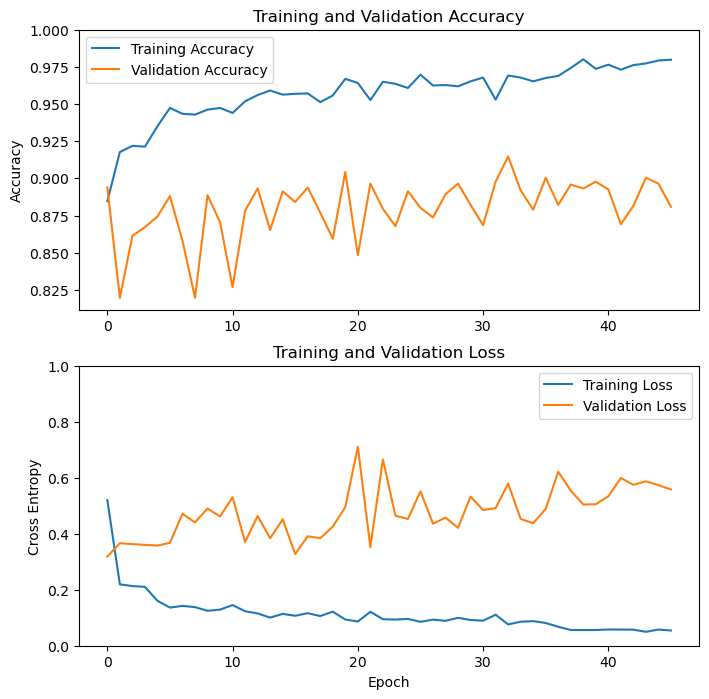

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

In [14]:
train_loss, train_acc = model.evaluate_generator(train_data)
test_loss, test_acc = model.evaluate_generator(validation_data)
print('Train: %.3f, Test: %.3f'% (train_acc, test_acc)) 

Instructions for updating:
Please use Model.evaluate, which supports generators.
Train: 0.940, Test: 0.891


In [15]:
#acc_vr, loss_vr = model.evaluate_generator(validation_data, steps=16)
#print(acc_vr)
#print(loss_vr)

In [16]:
#acc_test, loss_test = model.evaluate_generator(test_data, steps=16)
#print(acc_test)
#print(loss_test)